In [2]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

from sklearn.model_selection import train_test_split
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [20, 10]
%config InlineBackend.figure_format = 'retina'

In [42]:
df_rework = pd.read_csv('../datasets/euribor_historical_rework.csv', sep = ',', index_col = 0)

In [43]:
df_rework.head()

,date,euribor
0,2011-01,1.550
1,2011-02,1.714
2,2011-03,1.924
3,2011-04,2.086
4,2011-05,2.147


In [32]:
df_rework.drop(['date'], 1, inplace=True)

In [33]:
df_rework.head()

,euribor
0,1.550
1,1.714
2,1.924
3,2.086
4,2.147


In [34]:
prediction_days = 30

df_train = df_rework[:len(df_rework) - prediction_days]
df_test = df_rework[len(df_rework) - prediction_days:]

In [35]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

In [36]:
training_set = df_train.values
training_set = min_max_scaler.fit_transform(training_set)

x_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
x_train = np.reshape(x_train, (len(x_train), 1, 1))

In [37]:
model = Sequential()

model.add(LSTM(units = 4, activation = 'sigmoid', input_shape=(None, 1)))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4)                 96        
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.fit(x_train, y_train, batch_size = 5, epochs = 100)

Epoch 1/100
23/23 [==============================] - 15s 999us/step - loss: 0.1088
Epoch 2/100
23/23 [==============================] - 0s 909us/step - loss: 0.0859
Epoch 3/100
23/23 [==============================] - 0s 927us/step - loss: 0.0754
Epoch 4/100
23/23 [==============================] - 0s 958us/step - loss: 0.0734
Epoch 5/100
23/23 [==============================] - 0s 862us/step - loss: 0.0670
Epoch 6/100
23/23 [==============================] - 0s 862us/step - loss: 0.0779
Epoch 7/100
23/23 [==============================] - 0s 910us/step - loss: 0.0802
Epoch 8/100
23/23 [==============================] - 0s 819us/step - loss: 0.0776
Epoch 9/100
23/23 [==============================] - 0s 863us/step - loss: 0.0733
Epoch 10/100
23/23 [==============================] - 0s 773us/step - loss: 0.0831
Epoch 11/100
23/23 [==============================] - 0s 818us/step - loss: 0.0716
Epoch 12/100
23/23 [==============================] - 0s 819us/step - loss: 0.0778
Epoch 13/100

23/23 [==============================] - 0s 773us/step - loss: 0.0014
Epoch 99/100
23/23 [==============================] - 0s 773us/step - loss: 0.0016
Epoch 100/100
23/23 [==============================] - 0s 817us/step - loss: 0.0016


In [40]:
test_set = df_test.values

inputs = np.reshape(test_set, (len(test_set), 1))
inputs = min_max_scaler.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))

predicted_price = model.predict(inputs)
predicted_price = min_max_scaler.inverse_transform(predicted_price)

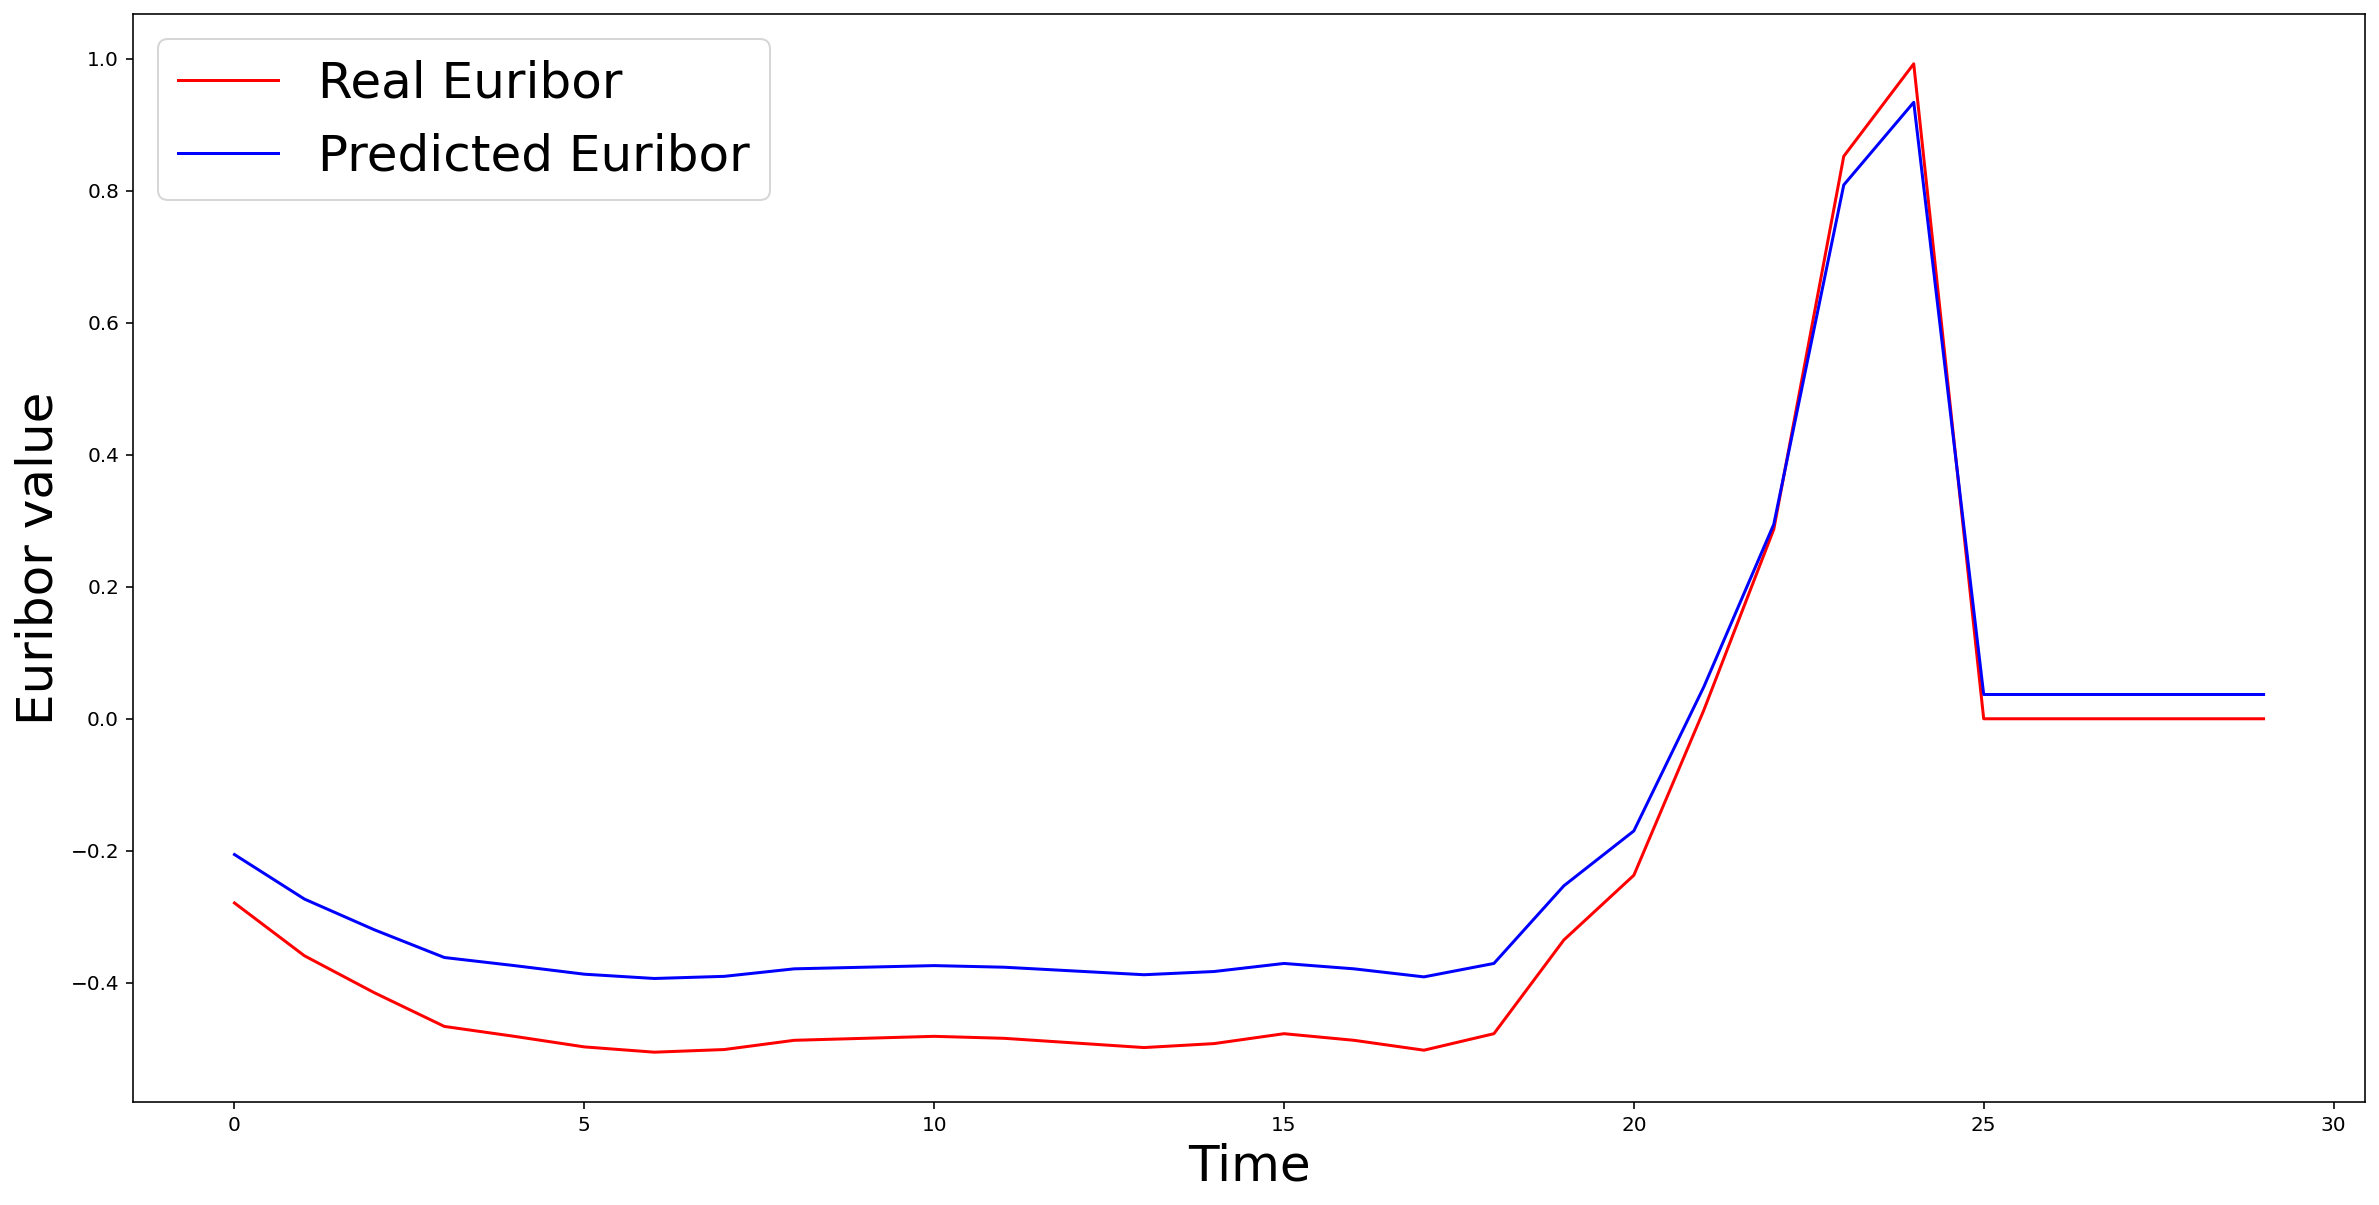

In [41]:
plt.plot(test_set[:, 0], color='red', label='Real Euribor')
plt.plot(predicted_price[:, 0], color = 'blue', label = 'Predicted Euribor')

plt.xlabel('Time', fontsize=25)
plt.ylabel('Euribor value', fontsize = 25)
plt.legend(loc = 'best', fontsize = 25)
plt.show()